In [ ]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
from nltk import PorterStemmer, bigrams as nltk_bigrams
from nltk.tokenize import MWETokenizer
import nltk
import re
from scipy.stats import chi2
from nltk.corpus import stopwords
from functools import lru_cache
from wordcloud import WordCloud

sns.set_style("darkgrid")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rune\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Final project - Computational Social Science (02476)

> Data is available [here](https://amazon-reviews-2023.github.io/)

### Constants and function definitions

In [3]:
REVIEW_DATA_FILE = 'dataset/Movies_and_TV.jsonl'
META_DATA_FILE = "dataset/meta_Movies_and_TV.jsonl"
EXTENDED_META_DATA_FILE = "dataset/meta_Movies_and_TV_extended.jsonl"

## 1. Data processing

### Process meta data

In [20]:
schema = {
    "title": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([
        pl.Field("Content advisory", pl.List(pl.Utf8)),
    ]),
    "parent_asin": pl.Utf8,
}

df_meta_1 = pl.read_ndjson(META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})
df_meta_2 = pl.read_ndjson(EXTENDED_META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})

df_meta = pl.concat([df_meta_1, df_meta_2])

# Map prices
df_meta = df_meta.with_columns(
    pl.col("price")
    .str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1)
    .cast(pl.Float64)
    .fill_null(-1)
)

# Map title
df_meta = df_meta.with_columns(
    pl.col("title")
      .str.replace(r"\[.*?\]", "", literal=False)
      .str.replace(r"\(.*?\)", "", literal=False)
      .str.strip_chars()
      .alias("title")
)

# Map description
df_meta = df_meta.with_columns(
    pl.when(
        pl.col("description").is_null() |
        (pl.col("description").list.eval(pl.element()).list.len() == 0)
    )
    .then(pl.lit([""]).cast(pl.List(pl.Utf8)))
    .otherwise(pl.col("description"))
    .alias("description")
)

df_meta = df_meta.with_columns(
    pl.col("description").list.get(0).alias("description") # TODO GET THE LONGEST DESCRIPTION
)

df_meta = df_meta.with_columns(
    pl.col("description").str.len_chars().alias("desc_len")
)

# Map Content advisory
df_meta = df_meta.with_columns(
    pl.struct(["details"]).map_elements(
        lambda s: s["details"]["Content advisory"] if s["details"] and "Content advisory" in s["details"] else [],
        return_dtype=pl.List(pl.Utf8)
    ).alias("details")
).rename({"details": "content_advisory"})

print(df_meta.height)

df_meta.limit(5)

748236


title,average_rating,rating_number,description,price,categories,content_advisory,asin,desc_len
str,f64,i64,str,f64,list[str],list[str],str,u32
"""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B00ABWKL3I""",396
"""One Perfect Wedding""",3.0,6,"""With her book tour in two week…",-1.0,"[""Comedy"", ""Drama"", ""Romance""]",[],"""B09WDLJ4HP""",219
"""How to Make Animatronic Charac…",5.0,7,"""Product Description""",64.99,"[""Movies & TV"", ""Genre for Featured Categories"", ""Special Interests""]",[],"""B00AHN851G""",19
"""Ode to Joy: Beethoven's Sympho…",4.3,35,"""This special Ode to Joy: Beeth…",5.99,"[""Documentary""]",[],"""B01G9ILXXE""",234
"""Ben 10: Alien Force""",4.7,360,"""Itâ€™s hero time again for Ben…",24.49,"[""Science Fiction"", ""Comedy"", … ""Drama""]",[],"""B009SIYXDA""",377


In [21]:
best_per_title = (
    df_meta.sort(["desc_len", "rating_number"], descending=[True, True])
    .group_by("title")
    .agg([
        pl.col("asin").unique().alias("asins"),
        pl.first("average_rating"),
        pl.first("rating_number"),
        pl.first("description"),
        pl.first("desc_len"),
        pl.first("price"),
        pl.first("categories"),
        pl.first("content_advisory")
    ])
    .with_columns(
        pl.col("asins").list.len().alias("num_asins")
    )
)
print(best_per_title.height)
best_per_title.sort("num_asins", descending=True).limit(5)

328400


title,asins,average_rating,rating_number,description,desc_len,price,categories,content_advisory,num_asins
str,list[str],f64,i64,str,u32,f64,list[str],list[str],u32
null,"[""B017V6U9HO"", ""B0B8RFXBW5"", … ""B00IA078Q6""]",null,null,"""""",0,-1.0,null,"[""Foul language"", ""sexual content""]",313988
"""Charlie Rose""","[""B000HBL6LE"", ""B000IU335G"", … ""B000KC8MOY""]",5.0,1,"""First, Dame Joan Sutherland sp…",980,-1.0,"[""Movies & TV"", ""Charlie Rose Store"", ""All Titles""]",[],65
"""A Christmas Carol""","[""B010QJ2M5U"", ""B08KW4B1QD"", … ""B000CGH51E""]",4.8,9932,"""Alastair Sim's tour-de-force p…",1424,9.99,"[""Movies & TV"", ""Featured Categories"", … ""Drama""]",[],54
"""Peter Pan""","[""B00Z9YZQCO"", ""B0009SUS4Q"", … ""B00004U8GV""]",4.5,154,"""Mary Martin *is* Peter Pan. Th…",1444,9.0,"[""Movies & TV"", ""Genre for Featured Categories"", ""Comedy""]",[],51
"""Sleeping Beauty""","[""B000B82SSS"", ""B006Z7Z3VS"", … ""B073YRD22D""]",4.8,12,"""Sleeping Beauty was the last a…",1814,27.5,"[""Movies & TV"", ""Featured Categories"", … ""Anime""]",[],50


### Process review data

In [22]:
df = pl.scan_ndjson(REVIEW_DATA_FILE).filter(pl.col('verified_purchase') == True)#.filter(pl.col('helpful_vote') != 0)
existing = set(df.collect_schema().keys())
drop_cols = {'images', 'style', 'verified_purchase', 'asin', 'helpful_vote', 'title'} 
keep_cols = list(existing - drop_cols)
df = df.select(keep_cols).rename({'parent_asin': 'asin'})
df = df.collect()
df.limit(5)

asin,rating,text,timestamp,user_id
str,f64,str,i64,str
"""B013488XFS""",5.0,"""Amazon, please buy the show! I…",1440385637000,"""AGGZ357AO26RQZVRLGU4D4N52DZQ"""
"""B00CB6VTDS""",5.0,"""My Kiddos LOVE this show!!""",1461100610000,"""AGKASBHYZPGTEPO6LWZPVJWB2BVA"""
"""B096Z8Z3R6""",3.0,"""Annabella Sciorra did her char…",1646271834582,"""AG2L7H23R5LLKDKLBEF2Q3L2MVDA"""
"""B001H1SVZC""",5.0,"""...isn't always how you expect…",1590639227074,"""AG2L7H23R5LLKDKLBEF2Q3L2MVDA"""
"""B06WVW16WY""",5.0,"""As you learn about the very un…",1586999747540,"""AG2L7H23R5LLKDKLBEF2Q3L2MVDA"""


In [7]:
df.height, df.get_column("asin").n_unique()

(13757796, 640455)

> All the asin with missing meta data

In [23]:
counts = (
    best_per_title
    .filter(pl.col("title").is_null())
    .explode("asins")
    .group_by("asins")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
)
counts

asins,count
str,u32
"""B010U2D9P0""",1
"""B004MJSESA""",1
"""B00FOILT8U""",1
"""B00FBT423G""",1
"""B00BWJBTM6""",1
…,…
"""B06XSS8Y1Q""",1
"""B00C5Z9SS8""",1
"""B00MQA5WFK""",1


In [24]:
asin_title_map = best_per_title.select([
    pl.col("title"),
    pl.col("asins"),
    pl.col("average_rating"),
    pl.col("price")
]).explode("asins").rename({"asins": "asin"}).sort("title", nulls_last=True).unique(subset=["asin"], keep="first")

df_reviews = df.join(
    asin_title_map,
    on="asin",
    how="left"
)

In [25]:
counts = (
    df_reviews
    .filter(pl.col("title").is_null())
    .group_by("asin")
    .agg(pl.len().alias("null_title_review_count"))
    .sort("null_title_review_count", descending=True)
)
counts.limit(10)

asin,null_title_review_count
str,u32
"""B007SPQZMC""",16501
"""B003AZCYCE""",16148
"""B01EN8FBG2""",15623
"""B01LWY8995""",14853
"""B013497N1C""",14730
"""B017AOY4WS""",14317
"""B00Z620OVW""",14122
"""B018GTUWPO""",14049
"""B01J776HVW""",13195


In [11]:
# df.get_column("asin").n_unique(), df_meta.get_column("parent_asin").n_unique()
# asins_in_df = df.get_column("asin").unique()
# asins_in_meta = df_meta.get_column("asin").unique()

# missing_asins = asins_in_df.filter(~asins_in_df.is_in(asins_in_meta.implode()))
# missing_asins.len()

In [26]:
# def filter_reviews(df, movie_threshold=5, review_threshold=5):
#     prev_rows = -1
#     while df.height != prev_rows:
#         prev_rows = df.height
#         valid_movies = (
#             df.group_by('asin')
#             .agg(pl.col('user_id').n_unique().alias('count'))
#             .filter(pl.col('count') >= review_threshold)
#             .get_column('asin')
#         )
#         df = df.filter(pl.col('asin').is_in(valid_movies.implode()))

#         valid_reviewers = (
#             df.group_by('user_id')
#             .agg(pl.col('asin').n_unique().alias('count'))
#             .filter(pl.col('count') >= movie_threshold)
#             .get_column('user_id')
#         )
#         df = df.filter(pl.col('user_id').is_in(valid_reviewers.implode()))
#     return df

# filtered_df = filter_reviews(df)
filtered_df = df_reviews.filter(pl.col("title").is_not_null())
print(filtered_df.height)
filtered_df.limit(5)

6611026


asin,rating,text,timestamp,user_id,title,average_rating,price
str,f64,str,i64,str,str,f64,f64
"""B013488XFS""",5.0,"""Amazon, please buy the show! I…",1440385637000,"""AGGZ357AO26RQZVRLGU4D4N52DZQ""","""Sneaky Pete""",4.6,-1.0
"""B00CB6VTDS""",5.0,"""My Kiddos LOVE this show!!""",1461100610000,"""AGKASBHYZPGTEPO6LWZPVJWB2BVA""","""Creative Galaxy""",4.8,-1.0
"""B0002J58ME""",5.0,"""This DVD was GREAT! I am a st…",1146713492000,"""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""10 Minute Solution: Pilates""",4.6,8.77
"""B079FLYB41""",5.0,"""Awesome movie! Must see.""",1560014052867,"""AHITBJSS7KYUBVZPX7M2WJCOIVKQ""","""Black Panther""",4.8,34.99
"""B01KBKKU7G""",4.0,"""It was pretty good. Had some p…",1474051189000,"""AHTTU2FL6FCNBBAESCJHOHHSSW7A""","""Seven Girlfriends""",3.2,12.99


In [27]:
reviewer_counts = (
    filtered_df.group_by('user_id')
    .agg(pl.col('asin').n_unique().alias('count'))
    .filter(pl.col('count') > 500)
).height

### Network

In [28]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by('user_id')
        .agg(pl.col('asin').unique().alias('asins'))
    )

    edges = defaultdict(int)

    for reviewers in tqdm(grouped['asins'], desc="Reviewer"):
        for pair in combinations(reviewers, 2):
            edges[tuple(sorted(pair))] += 1

    return [(a, b, count) for (a, b), count in edges.items()]

In [29]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 3010761/3010761 [01:09<00:00, 43148.46it/s]


47002433

In [30]:
Counter((w for _, _, w in movie_edgelist))

Counter({1: 44312704,
         2: 1968522,
         3: 393975,
         4: 138426,
         5: 63943,
         6: 35291,
         7: 21318,
         8: 14371,
         9: 9903,
         10: 7231,
         11: 5597,
         12: 4312,
         13: 3371,
         14: 2811,
         15: 2313,
         16: 2013,
         17: 1676,
         18: 1401,
         19: 1198,
         20: 1092,
         21: 938,
         22: 815,
         23: 690,
         24: 686,
         25: 532,
         27: 497,
         26: 471,
         28: 409,
         29: 382,
         30: 331,
         31: 318,
         32: 274,
         33: 248,
         34: 243,
         37: 198,
         35: 196,
         36: 185,
         38: 172,
         40: 171,
         39: 148,
         41: 139,
         44: 132,
         42: 131,
         43: 117,
         46: 104,
         48: 97,
         45: 96,
         47: 85,
         52: 83,
         56: 75,
         49: 73,
         50: 66,
         53: 65,
         51: 64,
         58

### Graph

In [31]:
WEIGHT_THRESHOLD = 10
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

43980

In [32]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}

In [33]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

In [34]:
len(G.nodes()), len(G.edges())

(14471, 43980)

In [35]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

6.078363623799323

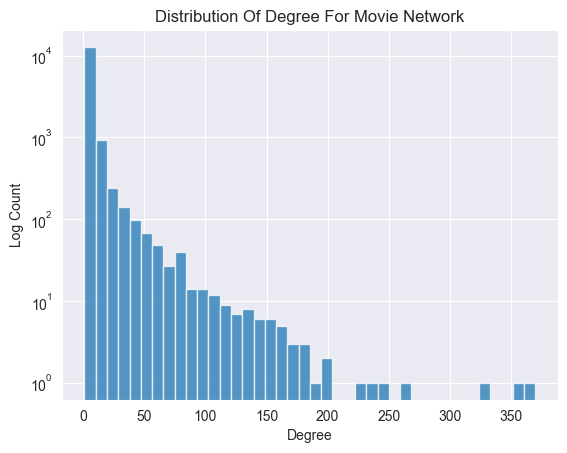

In [36]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75); 

### Community detection

In [37]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [38]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G, randomize=False, resolution=1)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [39]:
communities = louvain_partitions(G)
len(communities)

2379

In [40]:
modularity(G, communities)

0.8852005939902816

Counter({2: 1258,
         3: 428,
         4: 227,
         5: 112,
         6: 90,
         7: 58,
         8: 45,
         9: 30,
         10: 23,
         12: 15,
         11: 11,
         15: 8,
         13: 8,
         22: 4,
         17: 4,
         14: 3,
         16: 3,
         23: 3,
         18: 3,
         24: 3,
         37: 2,
         20: 2,
         45: 2,
         33: 2,
         19: 2,
         25: 2,
         523: 1,
         80: 1,
         416: 1,
         974: 1,
         707: 1,
         343: 1,
         111: 1,
         227: 1,
         118: 1,
         126: 1,
         207: 1,
         852: 1,
         129: 1,
         151: 1,
         130: 1,
         47: 1,
         268: 1,
         42: 1,
         39: 1,
         28: 1,
         108: 1,
         142: 1,
         29: 1,
         36: 1,
         40: 1,
         43: 1,
         32: 1,
         35: 1,
         31: 1,
         21: 1,
         38: 1})

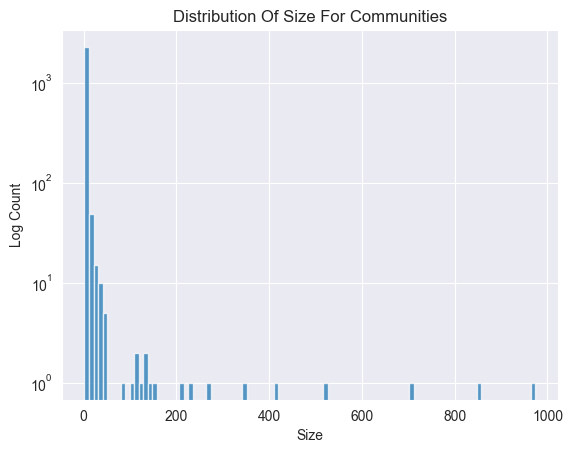

In [41]:
X = list(map(len, communities))
plt.yscale("log")
plt.title("Distribution Of Size For Communities")
plt.xlabel("Size")
plt.ylabel("Log Count")
plt.hist(X, 100, alpha=0.75);
Counter(X)

In [42]:
# Adding community labels to the df
movie_to_community = {
    movie_id: i
    for i, com in enumerate(communities)
    for movie_id in com
}

community_df = pl.DataFrame([
    {"asin": k, "community": v}
    for k, v in movie_to_community.items()
])

if "community" in filtered_df.columns:
    filtered_df = filtered_df.drop("community")

filtered_df = filtered_df.join(community_df, on="asin", how="left")
filtered_df.limit(2)

asin,rating,text,timestamp,user_id,title,average_rating,price,community
str,f64,str,i64,str,str,f64,f64,i64
"""B013488XFS""",5.0,"""Amazon, please buy the show! I…",1440385637000,"""AGGZ357AO26RQZVRLGU4D4N52DZQ""","""Sneaky Pete""",4.6,-1.0,0
"""B00CB6VTDS""",5.0,"""My Kiddos LOVE this show!!""",1461100610000,"""AGKASBHYZPGTEPO6LWZPVJWB2BVA""","""Creative Galaxy""",4.8,-1.0,0


In [43]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price", "community"]
df_attrs = filtered_df.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

### Text analysis

In [44]:
all_asin = [asin for com in communities for asin in com]

In [45]:
filtered_df.filter(pl.col("community").is_null()).height

3390230

In [46]:
filtered_df = filtered_df.filter(pl.col("community").is_not_null()) # Filter reviews that is not part of community - Removed with weight threshold

In [47]:
sum(list(map(len, communities))), len(G.nodes)

(14471, 14471)

In [48]:
# size of each community
community_sizes = (
    filtered_df
    .group_by("community")
    .agg(pl.col("asin").n_unique().alias("community_size"))
    .sort("community_size", descending=True)
)

community_sizes.limit(10)

community,community_size
i64,u32
5,974
20,852
7,707
0,523
4,416
10,343
61,268
13,227
18,207


In [49]:
filtered_df.filter(pl.col("community") == 175).select("title").unique()

title
str
"""Sing-Along Songs - You Can Fly…"
"""Sing Along Songs - Disneyland …"
"""Sing-Along Songs - The Bare Ne…"
"""Sing-Along Songs: Supercalifra…"
"""Disney's Sing Along Songs - Be…"
"""Sing-Along Songs - Pongo And P…"
"""Disney's Sing Along Songs - Th…"
"""Sing Along Songs - Flik's Musi…"
"""Disney's Sing Along Songs - Ve…"


### Tokens

In [51]:
# Tokenize and stemming reviews
stemmer = PorterStemmer()
# pattern = re.compile(r'https?://\S+|[^a-z\s]')
stop_words = stopwords.words('english')

@lru_cache(maxsize=20000)
def cached_stem(word):
    return stemmer.stem(word)

def tokenize(text, stem=True):
    text = text.lower()
    # text = pattern.sub('', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    return [cached_stem(t) for t in tokens] if stem else tokens

In [ ]:
filtered_df = filtered_df.with_columns(
    pl.Series("tokens", (tokenize(x) for x in filtered_df["text"]))
)

In [ ]:
filtered_df.limit(5)

timestamp,asin,user_id,rating,text,title,average_rating,price,community,tokens
i64,str,str,f64,str,str,f64,f64,i64,list[str]
1440385637000,"""B013488XFS""","""AGGZ357AO26RQZVRLGU4D4N52DZQ""",5.0,"""Amazon, please buy the show! I…","""Sneaky Pete""",4.6,-1.0,10,"[""amazon"", ""pleas"", … ""hook""]"
1461100610000,"""B00CB6VTDS""","""AGKASBHYZPGTEPO6LWZPVJWB2BVA""",5.0,"""My Kiddos LOVE this show!!""","""Creative Galaxy""",4.8,-1.0,10,"[""kiddo"", ""love"", ""show""]"
1146713492000,"""B0002J58ME""","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",5.0,"""This DVD was GREAT! I am a st…","""10 Minute Solution: Pilates""",4.6,8.77,1804,"[""dvd"", ""great"", … ""give""]"
1560014052867,"""B079FLYB41""","""AHITBJSS7KYUBVZPX7M2WJCOIVKQ""",5.0,"""Awesome movie! Must see.""","""Black Panther""",4.8,34.99,1,"[""awesom"", ""movi"", … ""see""]"
1411381209000,"""B000SMNL92""","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",4.0,"""CAN GO EITHER WAY ON THIS ONE;…","""Birds of Prey: The Complete Se…",4.5,20.99,979,"[""go"", ""either"", … ""time""]"


: 

In [ ]:
filtered_df = filtered_df.with_columns(
    pl.Series("bigrams", [list(nltk_bigrams(tokens)) for tokens in filtered_df["tokens"]])
)

In [ ]:
filtered_df.write_json("tokenizedReviews.json")
filtered_df.limit(5)

rating,user_id,text,timestamp,asin,title,average_rating,price,community,tokens,bigrams
f64,str,str,i64,str,str,f64,f64,i64,list[str],list[list[str]]
5.0,"""AGGZ357AO26RQZVRLGU4D4N52DZQ""","""Amazon, please buy the show! I…",1440385637000,"""B013488XFS""","""Sneaky Pete""",4.6,-1.0,0,"[""amazon"", ""pleas"", … ""hook""]","[[""amazon"", ""pleas""], [""pleas"", ""buy""], … [""im"", ""hook""]]"
5.0,"""AGKASBHYZPGTEPO6LWZPVJWB2BVA""","""My Kiddos LOVE this show!!""",1461100610000,"""B00CB6VTDS""","""Creative Galaxy""",4.8,-1.0,0,"[""kiddo"", ""love"", ""show""]","[[""kiddo"", ""love""], [""love"", ""show""]]"
5.0,"""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",1146713492000,"""B0002J58ME""","""10 Minute Solution: Pilates""",4.6,8.77,2245,"[""dvd"", ""great"", … ""give""]","[[""dvd"", ""great""], [""great"", ""stay""], … [""love"", ""give""]]"
5.0,"""AHITBJSS7KYUBVZPX7M2WJCOIVKQ""","""Awesome movie! Must see.""",1560014052867,"""B079FLYB41""","""Black Panther""",4.8,34.99,1,"[""awesom"", ""movi"", … ""see""]","[[""awesom"", ""movi""], [""movi"", ""must""], [""must"", ""see""]]"
4.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""CAN GO EITHER WAY ON THIS ONE;…",1411381209000,"""B000SMNL92""","""Birds of Prey: The Complete Se…",4.5,20.99,1785,"[""go"", ""either"", … ""time""]","[[""go"", ""either""], [""either"", ""way""], … [""one"", ""time""]]"


: 

In [ ]:
filtered_df = pl.read_json("tokenizedReviews.json")

In [ ]:
bigrams = (
    filtered_df
    .select(pl.col("bigrams"))
    .drop_nulls()
    .explode("bigrams")
    .get_column("bigrams")
    .to_list()
)

bigrams = [tuple(bg) for bg in bigrams if isinstance(bg, list) and len(bg) == 2]

filtered_df = filtered_df.drop("bigrams")

In [ ]:
bigram_counts = Counter(bigrams)
first_counts = Counter()
second_counts = Counter()
for (w1, w2), cnt in bigram_counts.items():
    first_counts[w1] += cnt
    second_counts[w2] += cnt

N = len(bigrams)
items = list(bigram_counts.items())
bgs, nii = zip(*items)
w1s, w2s = zip(*bgs)

f = np.fromiter((first_counts[w] for w in w1s), float)
s = np.fromiter((second_counts[w] for w in w2s), float)
o = np.array(nii, float)

nio = f - o
noi = s - o
noo = N - (o + nio + noi)

Eii = f * s / N
Eio = f * (N - s) / N
Eoi = (N - f) * s / N
Eoo = (N - f) * (N - s) / N

chi2_vals = (o - Eii)**2/Eii + (nio - Eio)**2/Eio + (noi - Eoi)**2/Eoi + (noo - Eoo)**2/Eoo
p_vals = chi2.sf(chi2_vals, 1)

mask = (o > 50) & (p_vals < 0.001)
collocs = {bgs[i]: int(o[i]) for i in np.nonzero(mask)[0]}

In [ ]:
tokenizer = MWETokenizer(list(collocs.keys()), separator="_")
filtered_df = filtered_df.with_columns(
    pl.Series("tokens", (tokenizer.tokenize(tokens) for tokens in filtered_df["tokens"]))
)

In [ ]:
filtered_df.limit(5)

rating,user_id,text,timestamp,asin,title,average_rating,price,community,tokens
f64,str,str,i64,str,str,f64,f64,i64,list[str]
5.0,"""AGGZ357AO26RQZVRLGU4D4N52DZQ""","""Amazon, please buy the show! I…",1440385637000,"""B013488XFS""","""Sneaky Pete""",4.6,-1.0,0,"[""amazon_pleas"", ""buy_show"", ""im_hook""]"
5.0,"""AGKASBHYZPGTEPO6LWZPVJWB2BVA""","""My Kiddos LOVE this show!!""",1461100610000,"""B00CB6VTDS""","""Creative Galaxy""",4.8,-1.0,0,"[""kiddo_love"", ""show""]"
5.0,"""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""","""This DVD was GREAT! I am a st…",1146713492000,"""B0002J58ME""","""10 Minute Solution: Pilates""",4.6,8.77,2245,"[""dvd_great"", ""stay_home"", … ""give""]"
5.0,"""AHITBJSS7KYUBVZPX7M2WJCOIVKQ""","""Awesome movie! Must see.""",1560014052867,"""B079FLYB41""","""Black Panther""",4.8,34.99,1,"[""awesom_movi"", ""must_see""]"
4.0,"""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""","""CAN GO EITHER WAY ON THIS ONE;…",1411381209000,"""B000SMNL92""","""Birds of Prey: The Complete Se…",4.5,20.99,1785,"[""go"", ""either_way"", … ""time""]"


In [ ]:
community_docs = (
    filtered_df
    .group_by("community")
    .agg(
        pl.concat_list("tokens").flatten().alias("tokens"), 
        pl.len().alias("num_reviews")
    ).sort("num_reviews", descending=True)
)
top5com = community_docs.limit(5)
top5com

community,tokens,num_reviews
i64,list[str],u32
0,"[""amazon_pleas"", ""buy_show"", … ""great""]",455849
1,"[""awesom_movi"", ""must_see"", … ""good""]",332923
4,"[""stori_continu"", ""charact"", … ""time_watch""]",285536
10,"[""fun"", ""color"", … ""two_thumb""]",204724
20,"[""realli_like"", ""movi_even"", … ""seller_product""]",81570


In [ ]:
def calculate_tf(tokens):
    total = len(tokens)
    counts = Counter(tokens)
    return {word: count / total for word, count in counts.items()}

def calculate_idf(docs: pl.DataFrame) -> dict[str, float]:
    N = docs.height
    df = (
        docs
        .explode("tokens")
        .unique(subset=["community", "tokens"])
        .group_by("tokens")
        .agg(pl.len().alias("df"))
        .with_columns((pl.lit(N) / pl.col("df")).log().alias("idf"))
        .sort("idf", descending=False)
    )
    return dict(zip(df["tokens"].to_list(), df["idf"].to_list()))

def calculate_tf_idf(tf, idf):
    tf_idf = {}
    for word, val in tf.items():
        tf_idf[word] = val * idf[word]
    return tf_idf

In [ ]:
idf = calculate_idf(community_docs)

In [ ]:
top_5_tf_idf = dict(zip(
    top5com["community"].to_list(),
    [calculate_tf_idf(calculate_tf(toks), idf) for toks in top5com["tokens"].to_list()]
))

### Word clouds

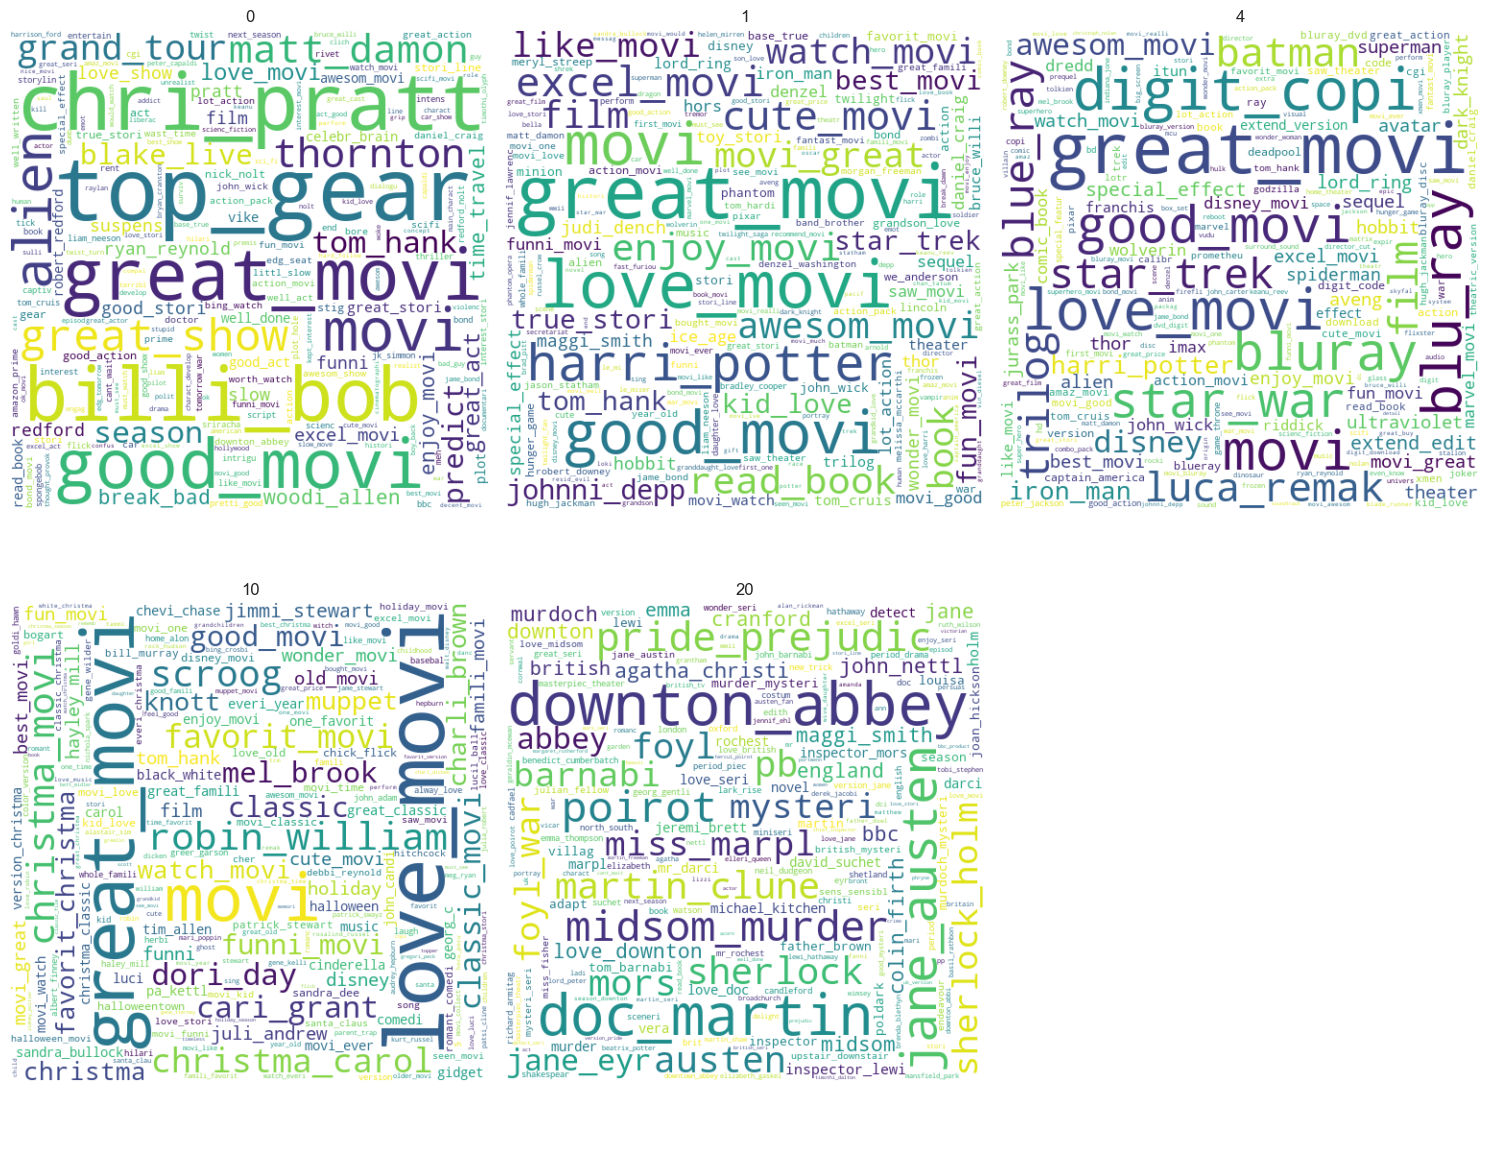

In [ ]:
def plot_word_clouds_grid(word_freq, top_movies = None, ncols=3):
    communities = list(word_freq.keys())
    nrows = -(-len(communities) // ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 6))
    axes = axes.flatten()

    for ax, comm in zip(axes, communities):
        cloud = WordCloud(background_color='white', height=500, width=500, colormap="viridis_r", contour_color='black', contour_width=0.5)
        cloud.generate_from_frequencies(word_freq[comm])
        movies = "\n".join(top_movies[comm]) if top_movies != None else str(comm)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_title(movies, fontsize=12)
        ax.axis('off')

    for ax in axes[len(communities):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_word_clouds_grid(top_5_tf_idf) # Plotting is based on tf-idf values and stemmed tokens